In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

raw_data_path = 'C:\股票数据'
# total_files_to_read = 5
all_stocks = pd.DataFrame()
tickers = set()

# iterate through all the files in the directory
for filename in os.listdir(raw_data_path):
    print(filename)
    # if it is a folder, iterate through all the files in the subfolder
    if os.path.isdir(raw_data_path + '/' + filename):
        for sub_filename in os.listdir(raw_data_path + '/' + filename):
            sub_filename = sub_filename.upper()

            # if the file extension is txt
            if sub_filename.endswith(".TXT") and (sub_filename.startswith('SH1A') or sub_filename.startswith('SH1B')):
                print(sub_filename)
                # total_files_to_read -= 1

                # read the file into a dataframe
                df = pd.read_csv(raw_data_path + '/' + filename + '/' + sub_filename, header=None)

                ticker = sub_filename.split('.')[0]
                df['ticker'] = ticker
                tickers.add(ticker)
                # df.columns = ['date', 'time', 'open', 'high', 'low', 'close', 'volume', 'amount','ticker']

                all_stocks = pd.concat([all_stocks, df])

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:\\股票数据'

In [2]:
# remove rows from all_stocks where the 0 column is 2009/06/22
all_indices = all_stocks[all_stocks[0] != '2009/06/22']

# merge the date and time columns (column 0 and 1 of all_stocks) into a single column
all_indices['date_time'] = all_indices[0] + ' ' + all_indices[1]

# remove rows that have duplicate column 'ticker' and 'date_time' combinations
all_indices = all_indices.drop_duplicates(['ticker', 'date_time'])

# pivot the table so that the tickers are the columns, representing closing prices
index_hist = all_indices.pivot(index='date_time', columns='ticker', values=5)

# remove sparce columns
index_hist.drop(['SH1B0010', 'SH1B0015', 'SH1B0016', 'SH1B0017', 'SH1B0300', 'SH1B0902'], axis=1, inplace=True)

# remove rows that have null values
index_hist.dropna(inplace=True)

# in place sort by date_time column
index_hist.sort_index(inplace=True)

# change precision to FP32
index_pct_hist = index_hist.astype('float32')

# calculate the percentage change of each ticker
index_pct_hist = index_pct_hist.pct_change()


C:\Users\Antares\AppData\Local\Temp\ipykernel_71260\2180642035.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_indices['date_time'] = all_indices[0] + ' ' + all_indices[1]


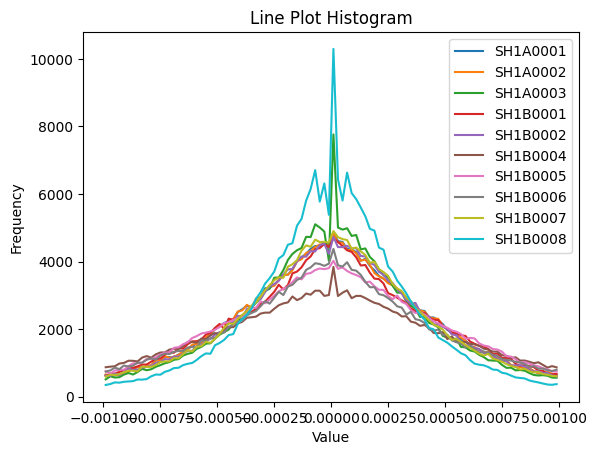

,mean,std,skew,kurtosis
ticker,,,,
SH1A0001,3.587082e-06,0.001008,3.342241,856.706482
SH1A0002,3.586085e-06,0.001009,3.415156,847.786987
SH1A0003,4.011898e-06,0.001078,6.782299,1195.898926
SH1B0001,3.770580e-06,0.001036,2.024214,676.003662
SH1B0002,5.102260e-06,0.000993,0.181330,726.026550
SH1B0004,7.360470e-06,0.001416,0.476795,435.144531
SH1B0005,3.690143e-06,0.001095,1.327094,545.330261
SH1B0006,3.922793e-06,0.001204,10.399022,1600.282104
SH1B0007,4.578385e-06,0.001044,2.630292,797.559265


In [31]:
# Compute histogram data
hist_data = {col: np.histogram((index_pct_hist)[col], bins=100, range=(-0.001,0.001)) for col in (index_pct_hist).columns}

# Plotting
for col, data in hist_data.items():
    if col == 'SH1B0009':
        continue
    centers = (data[1][:-1] + data[1][1:]) / 2  # Compute the bin centers
    plt.plot(centers, data[0], label=col)

plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Line Plot Histogram')
plt.show()

# calcluate averages and standard deviations of each ticker
df = pd.DataFrame()
df['mean'] = index_pct_hist.mean() # 4.247267e-06 in average
df['std'] = index_pct_hist.std()   # 0.0009819688 in average
df['skew'] = index_pct_hist.skew()
df['kurtosis'] = index_pct_hist.kurtosis()

df

In [39]:
# dump the dataframe to a file keeping the fp32 precision, but not in csv format
index_pct_hist.to_pickle('index_pct_hist.pkl')
